In [79]:
!pip install datasets
!pip install transformers
!pip install latentis==0.0.3
!pip install plotly
!pip install backports.strenum

In [80]:
from datasets import load_dataset
import math
from typing import Mapping, Sequence, List, Tuple, Optional
import itertools
from enum import auto

try:
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum

import torch
import numpy as np
import random

In [81]:
def seed_everything(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Relative projection (synthetic)

In [82]:
from scipy.stats import ortho_group
import pandas as pd
import plotly.express as px

In [83]:
def iso_transform(x, seed: int = 42, dtype: torch.dtype = torch.float32, return_transform: bool = False):
    """Any matrix x is transformed into an isometric matrix by multiplying it with a random orthogonal matrix."""
    opt_isometry: np.ndarray = ortho_group.rvs(x.shape[-1], random_state=seed)
    opt_isometry: torch.Tensor = torch.as_tensor(opt_isometry, dtype=dtype)
    out = x @ opt_isometry

    if return_transform:
        return out, opt_isometry

    return out

In [84]:
dtype = torch.float32

In [85]:
N: int = 100  # number of points for each space
D: int = 2  # dimensionality of each space
grid_mode: bool = D == 2 # used to disable plotting for higher dimensions
f"{grid_mode=}"

'grid_mode=True'

In [86]:
def build_space(noise: bool = False):
    x = torch.linspace(-10, 10, np.ceil(N ** (1 / 2)).astype(int), dtype=dtype)
    y = torch.linspace(-10, 10, np.ceil(N ** (1 / 2)).astype(int), dtype=dtype)

    xx, yy = torch.meshgrid(x, y, indexing="ij")

    x_space = torch.stack([xx, yy], dim=-1).reshape(-1, D)
    if noise:
        x_space *= torch.randn_like(x_space)

    return x_space


x_space = build_space(noise=False) if grid_mode else torch.randn(N, D, dtype=dtype)
x_space.shape

torch.Size([100, 2])

In [87]:
def transform_latents(
    x: torch.Tensor,
    norm_mode: Optional[str],
    seed: int,
    isometry_first: bool = True,
    translation: Optional[torch.Tensor] = None,
    grid_mode: bool = True,
) -> torch.Tensor:
    """Transforms the latents by applying an isometry and a specific rescaling.

    Args:
        x: The latents to transform.
        norm_mode: The mode to use for the norm. Can be one of "independent", "consistent", "smooth", "fixed", or None.
        seed: The seed to use for the various random generations.
        isometry_first: Whether to apply the isometry first or the norm.
        translation: The translation to apply to the latents.
        space: Whether the latents are arranged on a space or not.

    Returns:
        The transformed latents.
    """
    x = x.clone()
    if translation is not None:
        x += translation.unsqueeze(0)

    norm = torch.tensor([1], dtype=dtype)

    if norm_mode == "independent":
        seed_everything(seed=seed)
        norm = torch.abs((torch.randn(x.size(0), dtype=dtype) + 0.001) * 100)
    elif norm_mode == "consistent":
        space_side: int = int(x.size(0) ** (1 / 2))
        norm = x.reshape(space_side, space_side, D).sum(dim=-1) if grid_mode else x.sum(dim=-1)
        norm = (norm**2).flatten()
        norm = (norm - norm.min()) / (norm.max() - norm.min()) + 1
    elif norm_mode == "smooth":
        space_side: int = int(x.size(0) ** (1 / 2))
        norm = x.reshape(space_side, space_side, D).sum(dim=-1) if grid_mode else x.sum(dim=-1)
        norm = (norm**3).flatten()
        norm = (norm - norm.min()) / (norm.max() - norm.min()) + 1
    elif norm_mode == "fixed":
        x = x * 10

    if isometry_first:
        out = iso_transform(x, seed=seed) * norm.unsqueeze(-1)
    else:
        out = iso_transform(x * norm.unsqueeze(-1), seed=seed)

    return out


def random_transform(x: torch.Tensor, seed: int) -> torch.Tensor:
    """Applies a random transformation to the latent codes."""
    seed_everything(seed=seed)
    random_matrix = torch.randn((x.size(1), x.size(1)), dtype=dtype)
    return x @ random_matrix

In [88]:
seed: int = 42
translation = torch.tensor([20, 50], dtype=dtype) if grid_mode else torch.tensor([20])

abs_spaces = {
    "x": x_space,
    "Isometry(x)": transform_latents(x_space, norm_mode=None, seed=0, grid_mode=grid_mode),
    "IndependentRescale(Isometry(x))": transform_latents(x_space, norm_mode="independent", seed=1, grid_mode=grid_mode),
    "Translate(Isometry(x))": transform_latents(
        x_space, translation=translation, norm_mode=None, seed=2, grid_mode=grid_mode
    ),
    "ConsistentRescale(Isometry(x))": transform_latents(x_space, norm_mode="consistent", seed=3, grid_mode=grid_mode),
    "SmoothRescale(Isometry(x))": transform_latents(x_space, norm_mode="smooth", seed=4, grid_mode=grid_mode),
}
assert len(set(x.shape for x in abs_spaces.values())) == 1

In [89]:
# randomly select D points from each space to be the anchor points
anchor_indices = torch.randperm(x_space.shape[0], generator=torch.Generator().manual_seed(42))[:D]
# anchor_indices = [0, 99]

space2anchors: Mapping[str, torch.Tensor] = {space_name: space[anchor_indices, :] for space_name, space in abs_spaces.items()}

In [90]:
import torch
from torch import nn
import torch.nn.functional as F
from latentis.relative.projection import Projections, RelativeProjector
from latentis.transforms import Transforms

In [91]:
# transform the absolute spaces applying various policies
abs_l2_spaces = {
    space_name: Transforms.L2()(x=space, anchors=space)
    for space_name, space in abs_spaces.items()
}

abs_centered_spaces = {
    space_name: Transforms.Centering()(x=space, anchors=space)
    for space_name, space in abs_spaces.items()
}

rel_euclidean_spaces = {
    space_name: RelativeProjector(
        projection=Projections.EUCLIDEAN,
        abs_transforms=[Transforms.Centering()],
    )(x=space, anchors=space2anchors[space_name])
    for space_name, space in abs_spaces.items()
}

rel_cosine_spaces = {
    space_name: RelativeProjector(
        projection=Projections.COSINE,
    )(x=space, anchors=space2anchors[space_name])
    for space_name, space in abs_spaces.items()
}

rel_centered_cosine_spaces = {
    space_name: RelativeProjector(
        projection=Projections.COSINE,
        abs_transforms=[Transforms.Centering()],
    )(x=space, anchors=space2anchors[space_name])
    for space_name, space in abs_spaces.items()
}

In [92]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

plt.style.use("dark_background")

CMAP = plt.get_cmap("Spectral_r")

In [93]:
name2space = {
    "Absolute": abs_spaces,
    "L2(Absolute)": abs_l2_spaces,
    "Relative_Euclidean(Absolute)": rel_euclidean_spaces,
    "Relative(Absolute)": rel_cosine_spaces,
    "Relative(Center(Absolute))": rel_centered_cosine_spaces,
}

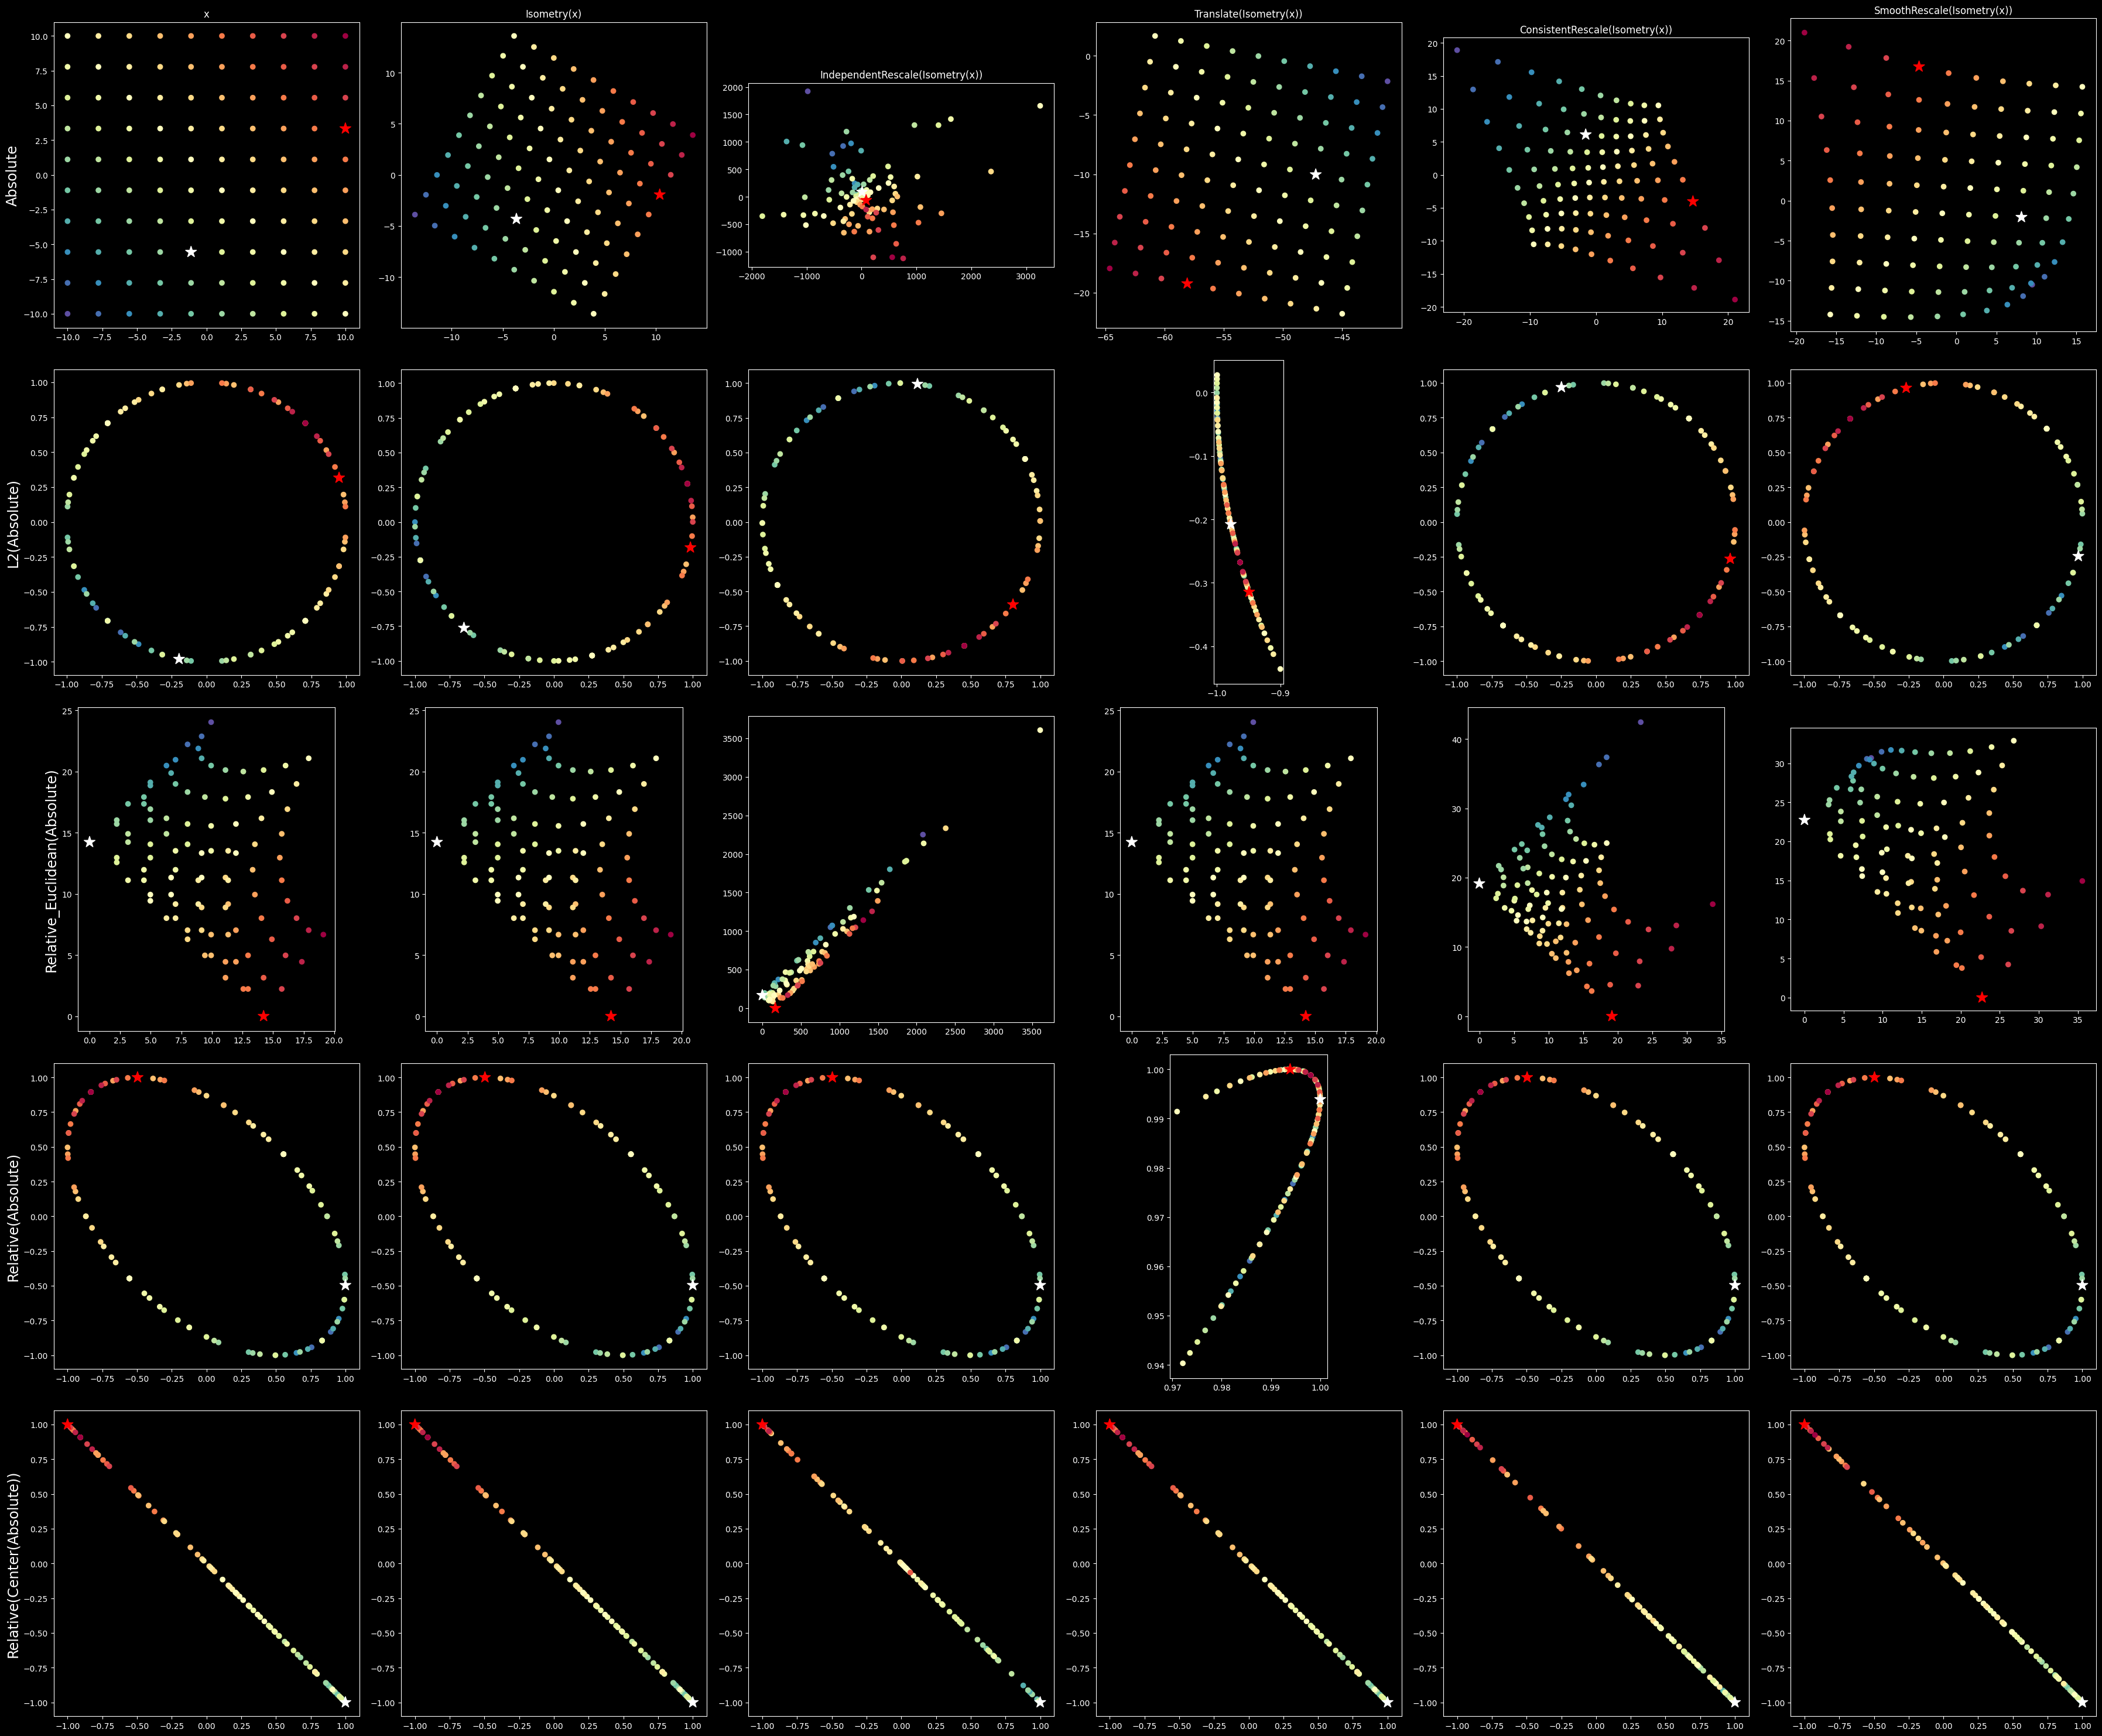

In [94]:
def plot_space(
    ax: Axes, space, space_name: Optional[str] = None, enc_type: Optional[str] = None
):
    """Plot a 2D space with anchors highlighted.

    Args:
        ax: The axis to plot on.
        space: The space to plot.
        space_name: The name of the space.
        enc_type: The encoding type.
    """
    anchors = space[anchor_indices, :]
    not_anchors = torch.ones(space.size(0))
    not_anchors[anchor_indices] = 0

    space = space[not_anchors.bool(), :]
    title = (
        f"{space_name if space_name is not None else ''} - {enc_type if enc_type is not None else ''}".strip()
        .strip("-")
        .strip()
    )
    if title != "-":
        ax.set_title(title)
    ax.scatter(x=space[:, 0], y=space[:, 1], c=colors[not_anchors.bool()], cmap=CMAP)
    ax.scatter(
        x=anchors[:, 0], y=anchors[:, 1], c=["w", "r"], marker="*", s=200
    )


colors = x_space.sum(axis=-1)

n_rows = len(name2space)
n_cols = len(abs_spaces)

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(n_cols * 6, n_rows * 6),
)

for row_index, (row_axis, (enc_type, spaces)) in enumerate(
    zip(axs, name2space.items()), start=1
):
    row_axis[0].set_ylabel(enc_type, rotation=90, size="xx-large")
    for col_index, (ax, (space_name, spaces)) in enumerate(
        zip(row_axis, spaces.items()), start=1
    ):
        ax: Axes
        ax.set_aspect("equal", "box")
        plot_space(
            ax=ax, space=spaces, space_name=space_name if row_index == 1 else None
        )

plt.tight_layout()
plt.show()

In [95]:
space_df = []
for space_type, spaces in name2space.items():
    for (space1_name, space1), (space2_name, space2) in itertools.product(spaces.items(), repeat=2):
        mse = F.mse_loss(space1, space2)
        cosine = F.cosine_similarity(space1, space2).mean()

        space_df.append(
            dict(
                type=space_type,
                space1=space1_name,
                space2=space2_name,
                mse=mse.item(),
                cosine_sim=cosine.item(),
            )
        )

space_df = pd.DataFrame(space_df)
space_df

,type,space1,space2,mse,cosine_sim
0,Absolute,x,x,0.000000,1.000000e+00
1,Absolute,x,Isometry(x),10.231724,8.744290e-01
2,Absolute,x,IndependentRescale(Isometry(x)),394912.437500,-8.642673e-09
3,Absolute,x,Translate(Isometry(x)),1531.481567,4.165384e-02
4,Absolute,x,ConsistentRescale(Isometry(x)),110.442116,5.960464e-10
...,...,...,...,...,...
175,Relative(Center(Absolute)),SmoothRescale(Isometry(x)),Isometry(x),0.003415,9.400000e-01
176,Relative(Center(Absolute)),SmoothRescale(Isometry(x)),IndependentRescale(Isometry(x)),0.129510,7.000000e-01
177,Relative(Center(Absolute)),SmoothRescale(Isometry(x)),Translate(Isometry(x)),0.003415,9.400000e-01
178,Relative(Center(Absolute)),SmoothRescale(Isometry(x)),ConsistentRescale(Isometry(x)),0.039305,9.000000e-01


In [96]:
px.density_heatmap(
    space_df,
    x="space1",
    y="space2",
    z="cosine_sim",
    color_continuous_scale="Spectral_r",
    title="Cosine similarity among spaces",
    facet_row="type",
    histfunc="avg",
    height=len(name2space) * 300,
    width=800,
)

# Model stitching

## Select a dataset from HuggingFace

In [97]:
# https://huggingface.co/datasets/cifar10
dataset_key: str = "cifar10"
data_key: str = "img"
label_key: str = "label"

In [98]:
data = load_dataset(dataset_key)
data

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [99]:
!pip install gdown
import gdown


In [100]:
!gdown https://drive.google.com/uc?id=1NOdWWLZdZzLpZsQwAZBWpYybD-pBabnf

Downloading...
From (original): https://drive.google.com/uc?id=1NOdWWLZdZzLpZsQwAZBWpYybD-pBabnf
From (redirected): https://drive.google.com/uc?id=1NOdWWLZdZzLpZsQwAZBWpYybD-pBabnf&confirm=t&uuid=ed62ef1a-a412-4b93-a0b3-a2d3162f47cb
To: /home/marco/logml/notebooks/model2abs_encodings.pt
100%|████████████████████████████████████████| 860M/860M [01:22<00:00, 10.4MB/s]


In [101]:
fit_data = data["train"].train_test_split(train_size=0.9, seed=42, stratify_by_column=label_key)
data["train"] = fit_data["train"]
data["val"] = fit_data["test"]
data

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['img', 'label'],
        num_rows: 5000
    })
})

In [102]:
import torchvision.transforms.functional as F

In [103]:
num_channels, width, height = F.to_tensor(data["train"][0][data_key]).shape
f"{num_channels=}, {width=}, {height=}"

'num_channels=3, width=32, height=32'

In [104]:
num_classes: int = data["train"].features[label_key].num_classes

In [105]:
labels: Mapping[str, torch.Tensor] = {
    split: torch.as_tensor(data[split][label_key])
    for split in data.keys()
}

In [106]:
from PIL.Image import Image
from torch.utils.data import DataLoader
import functools
from tqdm import tqdm

In [107]:
DEVICE: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Select pre-trained models from HuggingFace to be used as encoders

In [108]:
from transformers import AutoModel, AutoProcessor
from torch.utils.data import TensorDataset

In [109]:
ENCODERS = [
    "microsoft/resnet-50", # https://huggingface.co/microsoft/resnet-50
    "google/vit-base-patch16-224", # https://huggingface.co/google/vit-base-patch16-224
    "google/vit-base-patch32-384", # https://huggingface.co/google/vit-base-patch32-384
]

In [110]:
# load the models and their processors
model_name2model = {model_name: AutoModel.from_pretrained(model_name).eval() for model_name in ENCODERS}
model_name2processor = {model_name: AutoProcessor.from_pretrained(model_name) for model_name in ENCODERS}

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch32-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use th

In [111]:
for model_name, model in model_name2model.items():
    print(f"Model {model_name} = {model.num_parameters()} parameters.")

Model microsoft/resnet-50 = 23508032 parameters.
Model google/vit-base-patch16-224 = 86389248 parameters.
Model google/vit-base-patch32-384 = 88118784 parameters.


In [112]:
def collate_fn(images: Sequence[Image], transform):
    """
        Collate function to be used when loading images with a DataLoader.
        Args:
            images: Sequence of PIL images.
            transform: Transform to apply to the images.
    """
    images: Sequence[torch.Tensor] = [transform(image[data_key].convert("RGB")).convert_to_tensors("pt") for image in images]
    images = [image["pixel_values"][0] for image in images]
    images: torch.Tensor = torch.stack(images, dim=0)

    return {"image": images}

@torch.no_grad()
def encode_data(dataset, split: str, transform, encoder, encoder_name: str, batch_size=128) -> torch.Tensor:
    """
        Encode the images in a dataset using a given encoder.
        Args:
            dataset: Dataset to encode.
            split: Split of the dataset to encode.
            transform: Transform to apply to the images.
            encoder: Encoder to use to encode the images.
            encoder_name: Name of the encoder.
            batch_size: Batch size to use when encoding.
        Returns:
            Encoded images.
    """
    embeddings = []
    loader = DataLoader(
        dataset[split],
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=8,
        collate_fn=functools.partial(
            collate_fn,
            transform=transform,
        ),
    )

    for batch in tqdm(loader, desc=f"Embedding {split} samples with {encoder_name}"):
        encoded = encoder(batch["image"].to(DEVICE), output_hidden_states=True)
        encoded = encoded["pooler_output"].squeeze()
        embeddings.append(encoded.cpu())

    return torch.cat(embeddings, dim=0)

In [113]:
model2abs_encodings = {}

In [114]:
# this can be slow on Colab, so we'll just load the encodings for the original models from pre-computed files
compute: bool = False
if compute:
    for model_name in ENCODERS:
        model, processor = (
            model_name2model[model_name],
            model_name2processor[model_name],
        )
        model.to(DEVICE)
        split2model_encodings = {
            split: encode_data(
                dataset=data,
                split=split,
                encoder=model,
                encoder_name=model_name,
                transform=processor,
            )
            for split in data.keys()
        }
        model2abs_encodings[model_name] = split2model_encodings
        model.cpu()
    # torch.save(model2abs_encodings, "model2abs_encodings.pt")
else:
    model2abs_encodings = torch.load("./model2abs_encodings.pt")
    assert all(
        encoder in model2abs_encodings.keys() for encoder in ENCODERS
    ), "There is a missing encoder in the pre-computed ones"

RelativeProjector is an object that takes care of the relative representation of a set of points "x" with respect to a set of anchor points "anchors".

You can select the projection function from a list of available functions, or you can define your own function as in https://github.com/Flegyas/Latentis/blob/main/src/latentis/relative/projection.py .

You can specify both a list of transformations to apply to the points (including the anchors) before the projection (abs_transforms), and a list of transformations to apply to the projected points (rel_transforms).

In [115]:
num_anchors: int = 1500

In [116]:
torch.manual_seed(seed)
anchor_indices = torch.randperm(len(data["train"]))[:num_anchors]
anchor_indices.shape

torch.Size([1500])

In [117]:
rel_proj = RelativeProjector(
    projection=Projections.COSINE,
    # abs_transforms=[Transforms.StandardScaling()],
    # rel_transforms=[Transforms.L2()],
).to(DEVICE)

In [118]:
def to_relative(
    encodings: torch.Tensor,
    anchors: torch.Tensor,
    rel_proj: RelativeProjector,
    batch_size: int = 4000,
) -> torch.Tensor:
    """Converts absolute encodings to relative encodings.

    Args:
        encodings (torch.Tensor): Absolute encodings.
        anchors (torch.Tensor): Anchors.
        rel_proj (RelativeProjector): Relative projector.
        batch_size (int, optional): Batch size. Defaults to 4000.

    Returns:
        torch.Tensor: Relative encodings.
    """
    rel_proj.to(DEVICE)
    rel_encodings = []

    for batch in encodings.split(batch_size):
        batch = batch.to(DEVICE)
        rel_encodings.append(rel_proj(batch, anchors=anchors).cpu())

    rel_proj.cpu()

    return torch.cat(rel_encodings, dim=0)

In [119]:
model2rel_encodings = {}

for model_name in ENCODERS:
    # obtain model-specific absolute encodings for the anchors
    anchors: torch.Tensor = model2abs_encodings[model_name]["train"][anchor_indices].to(
        DEVICE
    )

    # convert all absolute encodings to relative encodings (for all splits)
    split2rel_encodings = {
        split: to_relative(
            encodings=abs_encodings,
            anchors=anchors,
            rel_proj=rel_proj,
        )
        for split, abs_encodings in model2abs_encodings[model_name].items()
    }

    model2rel_encodings[model_name] = split2rel_encodings

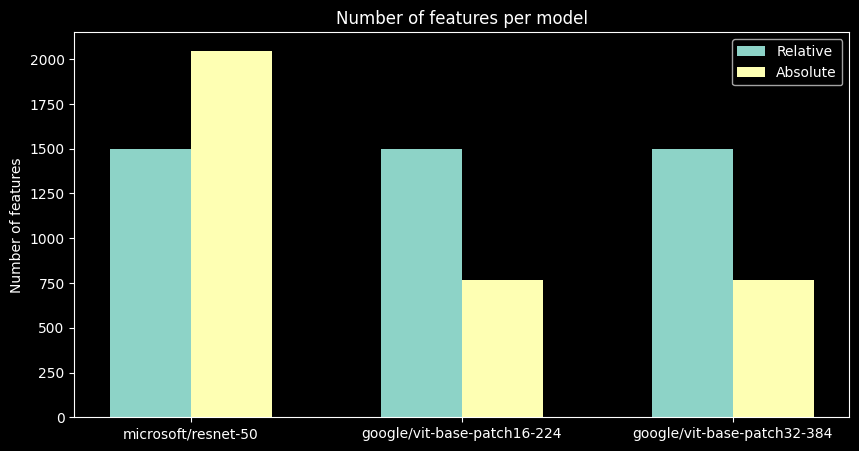

In [120]:
absolute_sizes = {model_name: encodings["train"].size(1) for model_name, encodings in model2abs_encodings.items()}
relative_sizes = {model_name: encodings["train"].size(1) for model_name, encodings in model2rel_encodings.items()}

# plot a bar chart grouping by relative and absolute
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    np.arange(len(relative_sizes)),
    list(relative_sizes.values()),
    width=0.3,
    label="Relative",
)
ax.bar(
    np.arange(len(absolute_sizes)) + 0.3,
    list(absolute_sizes.values()),
    width=0.3,
    label="Absolute",
)
ax.set_xticks(np.arange(len(relative_sizes)) + 0.3 / 2)
ax.set_xticklabels(list(relative_sizes.keys()))
ax.set_ylabel("Number of features")
ax.set_title("Number of features per model")
ax.legend()
plt.show()

In [121]:
class Reduction(StrEnum):
    INDEPENDENT_PCA = auto()
    TSNE = auto()
    FIRST_DIMS = auto()

In [122]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [123]:
def reduce(model2encodings: Mapping[str, torch.Tensor], reduction: Reduction, seed: int = 42):
    models, spaces = zip(*model2encodings.items())

    if reduction == Reduction.INDEPENDENT_PCA:
        spaces = [PCA(2, random_state=seed).fit_transform(space) for space in spaces]
    # elif reduction == Reduction.SHARED_PCA:
    #     pca = PCA(2, random_state=seed)
    #     pca = pca.fit(spaces[0])
    #     spaces = [pca.transform(space) for space in spaces]
    elif reduction == Reduction.TSNE:
        spaces = [TSNE(2, random_state=seed, learning_rate="auto", init="pca").fit_transform(space) for space in spaces]
    elif reduction == Reduction.FIRST_DIMS:
        spaces = [space[:, [0, 1]] for space in spaces]
    else:
        raise NotImplementedError

    return dict(zip(models, spaces))

In [124]:
# apply different reduction methods to the encodings (both absolute and relative)
reduced_abs_encodings = {
    reduction: reduce(
        model2encodings={
            model_name: split2encodings["train"][
                anchor_indices
            ]  # fit only on the anchor indices to speed up
            for model_name, split2encodings in model2abs_encodings.items()
        },
        reduction=reduction,
    )
    for reduction in Reduction
}

reduced_rel_encodings = {
    reduction: reduce(
        model2encodings={
            model_name: split2encodings["train"][
                anchor_indices
            ]  # fit only on the anchor indices to speed up
            for model_name, split2encodings in model2rel_encodings.items()
        },
        reduction=reduction,
    )
    for reduction in Reduction
}

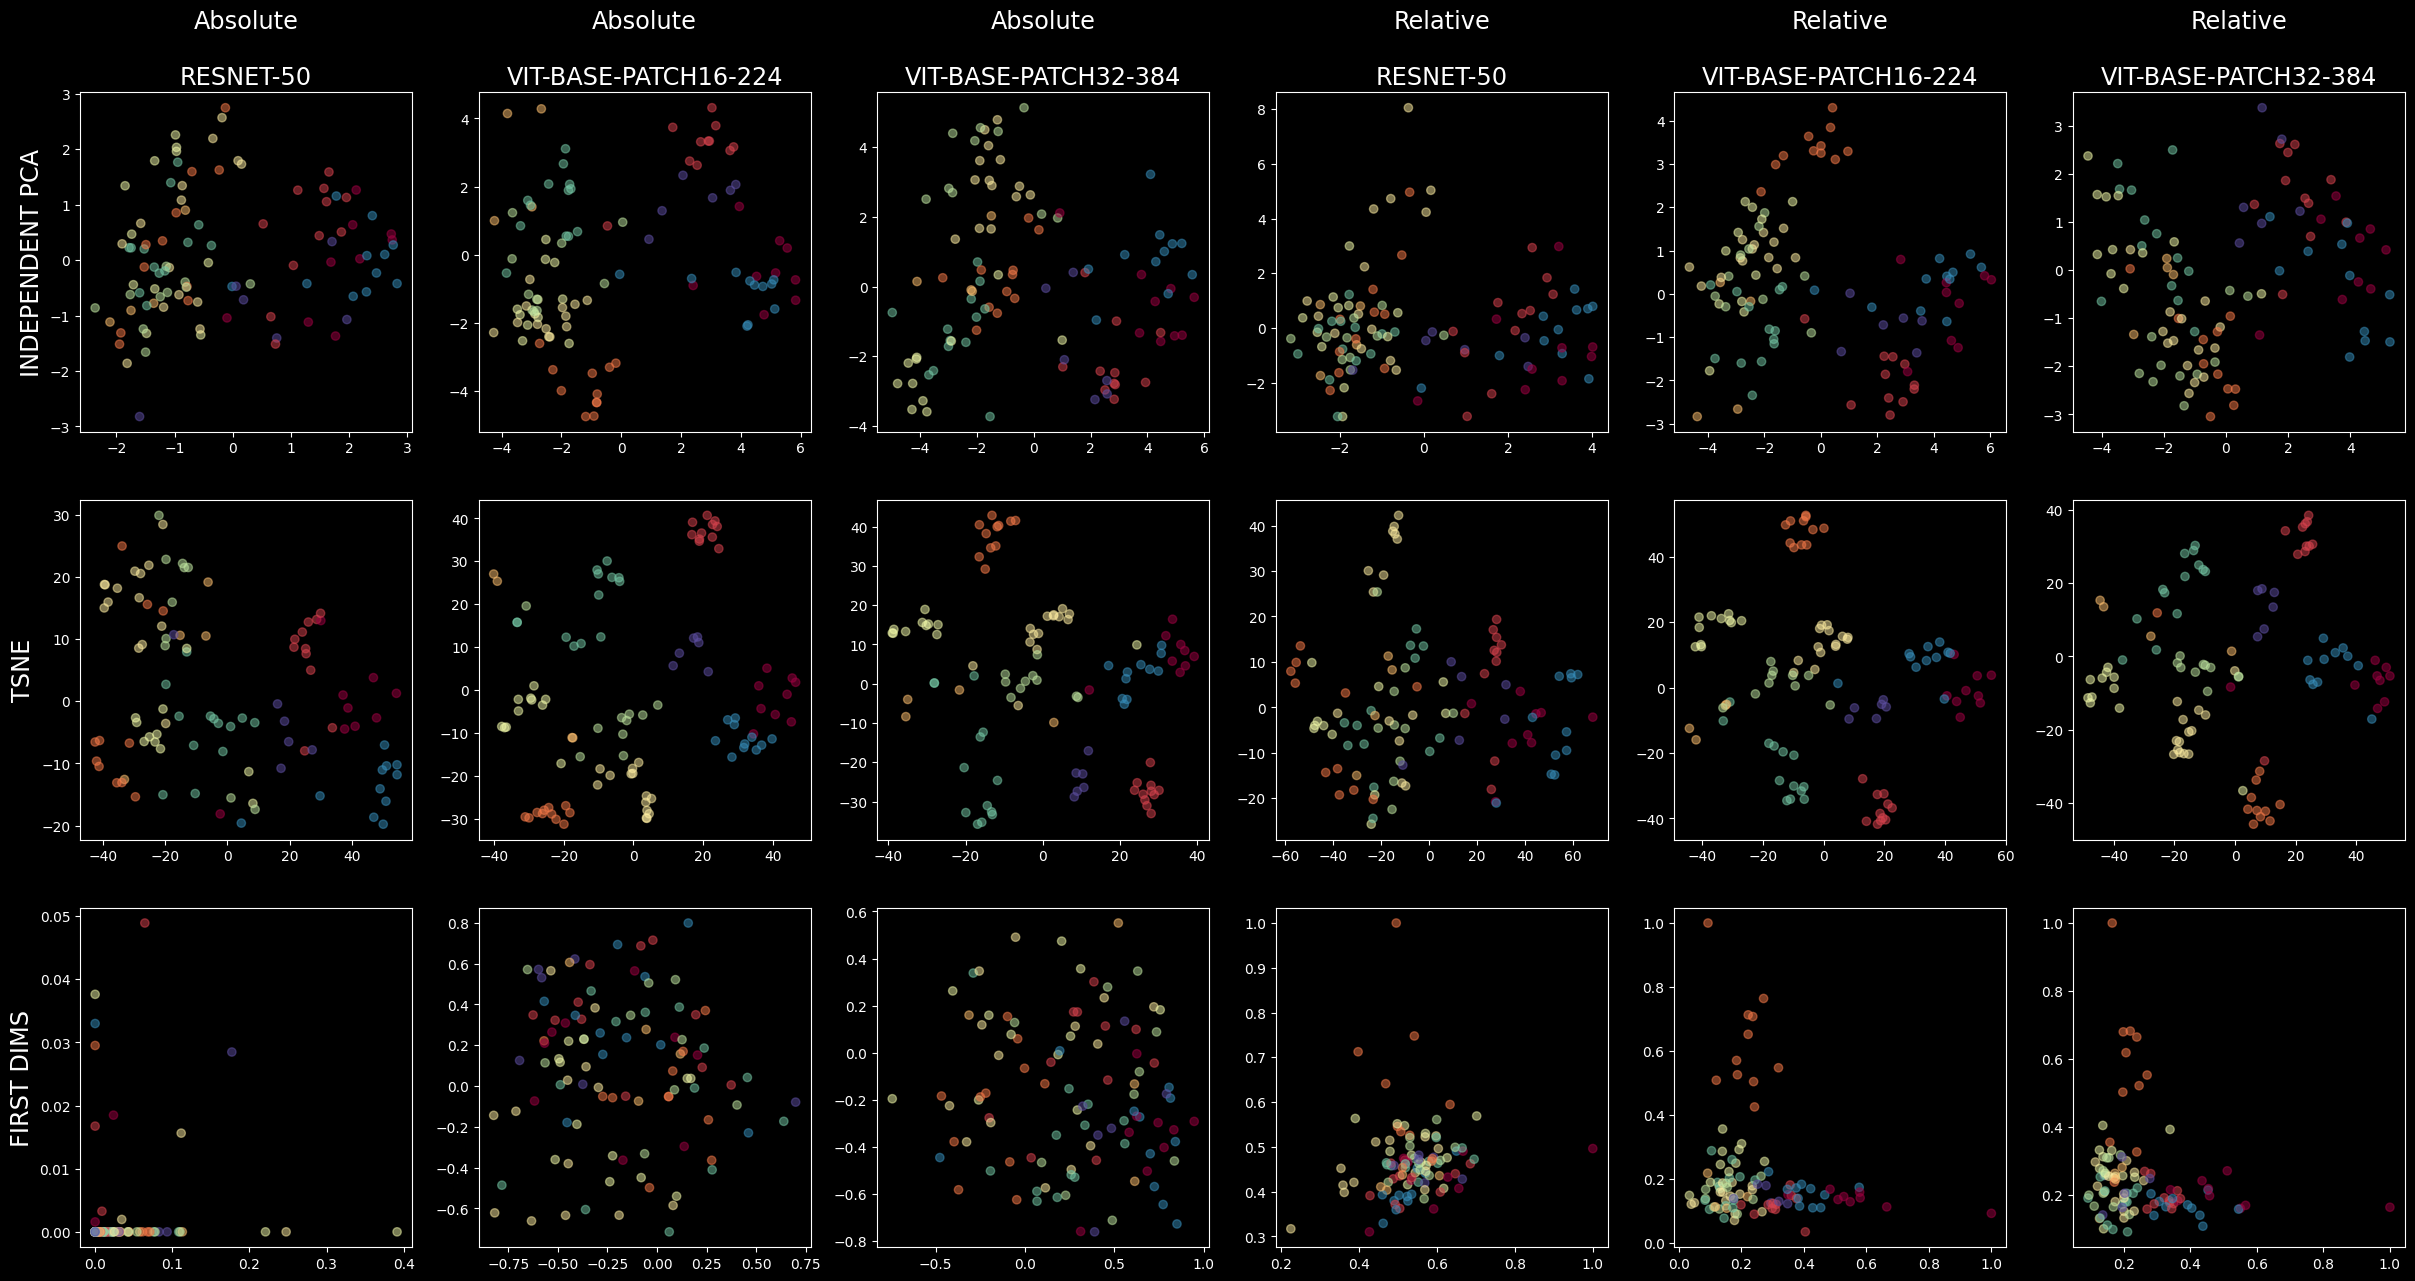

In [125]:
n_rows = len(Reduction)
n_cols = len(model2abs_encodings) * 2

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))

for row, reduction in enumerate(Reduction):
    col = 0
    axs[row][0].set_ylabel(
        reduction.upper().replace("_", " "), rotation=90, size="xx-large"
    )

    for model2encodings, encoding_type in (
        (reduced_abs_encodings[reduction], "Absolute"),
        (reduced_rel_encodings[reduction], "Relative"),
    ):
        for model, grid_mode in model2encodings.items():
            ax = axs[row, col]
            if row == 0:
                # add an header only for the first row and group of columns
                ax.set_title(
                    f"{encoding_type}\n\n{model.upper().replace('_', ' ').split('/')[-1]}",
                    size="xx-large",
                )
            ax.scatter(
                grid_mode[:100, 0],
                grid_mode[:100, 1],
                c=labels["train"][anchor_indices][:100],
                alpha=0.5,
                cmap=CMAP,
            )
            col += 1
fig.show()

In [126]:
from torch import nn
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, TensorDataset

In [127]:
def train_decoder(
    encodings: Mapping[str, torch.Tensor],
    labels: Mapping[str, torch.Tensor],
    num_classes: int,
    encoding_type: str,
    encoder_name: str,
    hidden_dim: int = 500,
    num_epochs: int = 5,
):
    """
    Trains a decoder model on the frozen encodings from a pretrained encoder model.

    Args:
        encodings: A mapping from dataset split to encodings.
        labels: A mapping from dataset split to labels.
        num_classes: The number of classes in the dataset.
        encoding_type: The type of encoding used (relative or absolute).
        encoder_name: The name of the pretrained encoder model.
        hidden_dim: The dimension of the hidden layer in the decoder model.

    Returns:
        decoder: The trained decoder model.
        info: A dictionary containing the training and validation metrics.
    """
    input_dim: int = encodings["train"].size(1)

    # define the decoder model
    decoder = nn.Sequential(
        nn.LayerNorm(input_dim),
        nn.Linear(input_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, num_classes),
        nn.ReLU(),
    ).to(DEVICE)

    train_loader = TensorDataset(encodings["train"], labels["train"])
    val_loader = TensorDataset(encodings["val"], labels["val"])
    # test_loader = TensorDataset(encodings["test"], labels["test"])

    train_loader = DataLoader(
        train_loader, batch_size=64, shuffle=True, pin_memory=True, num_workers=2
    )
    val_loader = DataLoader(
        val_loader, batch_size=64, shuffle=False, pin_memory=True, num_workers=2
    )
    # test_loader = DataLoader(test_loader, batch_size=32, shuffle=False, pin_memory=True)

    optimizer = torch.optim.Adam(decoder.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()

    val_accuracy = Accuracy("multiclass", num_classes=num_classes, top_k=1).to(DEVICE)

    info = {"train_loss": [], "val_loss": [], "val_accuracy": []}

    for epoch in tqdm(
        list(range(num_epochs)),
        desc=f"Training {encoding_type} Decoder on frozen encodings from {encoder_name}",
    ):
        decoder.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = decoder(x.to(DEVICE))
            loss = criterion(y_hat, y.to(DEVICE))
            loss.backward()
            info["train_loss"].append(loss.detach().cpu().item())
            optimizer.step()

        decoder.eval()
        with torch.no_grad():
            for x, y in val_loader:
                y = y.to(DEVICE)
                y_hat = decoder(x.to(DEVICE))
                loss = criterion(y_hat, y)
                val_accuracy.update(y_hat, y)

        info["val_accuracy"].append(val_accuracy.compute().cpu().item())
        val_accuracy.reset()

    return decoder.eval().cpu(), info

In [128]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [129]:
def plot_info(abs_info: Mapping, rel_info: Mapping, model_name: str):
    abs_val_accuracy: Sequence[float] = abs_info["val_accuracy"]
    rel_val_accuracy: Sequence[float] = rel_info["val_accuracy"]

    accuracy = list(abs_val_accuracy) + list(rel_val_accuracy)
    epoch = list(range(len(abs_val_accuracy))) * 2
    encoding_type = ["absolute"] * len(abs_val_accuracy) + ["relative"] * len(
        rel_val_accuracy
    )

    df = pd.DataFrame(
        {"accuracy": accuracy, "epoch": epoch, "encoding_type": encoding_type}
    )

    fig = px.line(
        df,
        x="epoch",
        y="accuracy",
        line_group="encoding_type",
        width=800,
        height=600,
        title=f"Validation accuracy for {model_name}",
        color="encoding_type",
    )

    fig.show()

In [130]:
model_name2abs_decoder = {}
model_name2rel_decoder = {}

for model_name in ENCODERS:
    abs_encodings = model2abs_encodings[model_name]
    abs_decoder, abs_info = train_decoder(
        encodings=abs_encodings,
        labels=labels,
        num_classes=num_classes,
        encoding_type="Absolute",
        encoder_name=model_name,
    )

    model_name2abs_decoder[model_name] = abs_decoder

    rel_encodings = model2rel_encodings[model_name]
    rel_decoder, rel_info = train_decoder(
        encodings=rel_encodings,
        labels=labels,
        num_classes=num_classes,
        encoding_type="Relative",
        encoder_name=model_name,
    )

    plot_info(abs_info=abs_info, rel_info=rel_info, model_name=model_name)

    model_name2rel_decoder[model_name] = rel_decoder

Training Absolute Decoder on frozen encodings from microsoft/resnet-50: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
Training Relative Decoder on frozen encodings from microsoft/resnet-50: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Training Absolute Decoder on frozen encodings from google/vit-base-patch16-224: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
Training Relative Decoder on frozen encodings from google/vit-base-patch16-224: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Training Absolute Decoder on frozen encodings from google/vit-base-patch32-384: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
Training Relative Decoder on frozen encodings from google/vit-base-patch32-384: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


In [131]:
@torch.no_grad()
def eval_stitching(
    encodings: torch.Tensor,
    decoder: nn.Module,
    labels: torch.Tensor,
    num_classes: int,
    encoding_type: str,
    model1: str,
    model2: str
):
    decoder.eval().to(DEVICE)
    dataset = TensorDataset(encodings, labels)

    loader = DataLoader(
        dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=2
    )
    accuracy = Accuracy("multiclass", num_classes=num_classes, top_k=1).to(DEVICE)

    for x, y in tqdm(loader, desc=f"Evaluating {encoding_type} stiching performances on ({model1}, {model2})"):
        y = y.to(DEVICE)
        y_hat = decoder(x.to(DEVICE))
        accuracy.update(y_hat, y)

    decoder.cpu()

    return accuracy.compute().cpu().item()

Following the stitching setting outlined in the original paper (Section 5), we are going to combine encodings extracted from model X with decoders trained on Y. The resulting XY model will be evaluated on the shared test set (same dataset, different encoding spaces).

In [132]:
abs_pair2score = {}
rel_pair2score = {}

for model1, model2 in itertools.product(ENCODERS, repeat=2):
    # not all the absolute encodings have the same dimensionality
    if model2abs_encodings[model1]["test"].shape[1] == model2abs_encodings[model2]["test"].shape[1]:
        abs_pair2score[(model1, model2)] = eval_stitching(
            encodings=model2abs_encodings[model1]["test"],
            decoder=model_name2abs_decoder[model2],
            labels=labels["test"],
            num_classes=num_classes,
            encoding_type="Absolute",
            model1=model1,
            model2=model2,
        )

    # but all the relative encodings do
    rel_pair2score[(model1, model2)] = eval_stitching(
        encodings=model2rel_encodings[model1]["test"],
        decoder=model_name2rel_decoder[model2],
        labels=labels["test"],
        num_classes=num_classes,
        encoding_type="Relative",
        model1=model1,
        model2=model2,
    )

Evaluating Absolute stiching performances on (microsoft/resnet-50, microsoft/resnet-50): 100%|██████████| 157/157 [00:00<00:00, 418.17it/s]
Evaluating Relative stiching performances on (microsoft/resnet-50, microsoft/resnet-50): 100%|██████████| 157/157 [00:00<00:00, 471.96it/s]
Evaluating Relative stiching performances on (microsoft/resnet-50, google/vit-base-patch16-224): 100%|██████████| 157/157 [00:00<00:00, 474.98it/s]
Evaluating Relative stiching performances on (microsoft/resnet-50, google/vit-base-patch32-384): 100%|██████████| 157/157 [00:00<00:00, 468.82it/s]
Evaluating Relative stiching performances on (google/vit-base-patch16-224, microsoft/resnet-50): 100%|██████████| 157/157 [00:00<00:00, 471.53it/s]
Evaluating Absolute stiching performances on (google/vit-base-patch16-224, google/vit-base-patch16-224): 100%|██████████| 157/157 [00:00<00:00, 487.16it/s]
Evaluating Relative stiching performances on (google/vit-base-patch16-224, google/vit-base-patch16-224): 100%|██████████

In [133]:
# Build heatmaps for the stitching scores of both absolute and relative models
abs_heatmap = np.zeros((len(ENCODERS), len(ENCODERS)))
for (model_name1, model_name2), score in abs_pair2score.items():
    abs_heatmap[ENCODERS.index(model_name1), ENCODERS.index(model_name2)] = score

rel_heatmap = np.zeros((len(ENCODERS), len(ENCODERS)))
for (model_name1, model_name2), score in rel_pair2score.items():
    rel_heatmap[ENCODERS.index(model_name1), ENCODERS.index(model_name2)] = score

In [134]:
abs_fig = go.Figure(
    data=go.Heatmap(
        z=abs_heatmap.T,
        x=ENCODERS,
        y=ENCODERS,
        colorscale="Spectral_r",
    )
)
rel_fig = go.Figure(
    data=go.Heatmap(
        z=rel_heatmap.T,
        x=ENCODERS,
        y=ENCODERS,
        colorscale="Spectral_r",
    )
)

fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Absolute", "Relative"), shared_yaxes=True, shared_xaxes=True
)
fig.add_trace(abs_fig.data[0], row=1, col=1)
fig.add_trace(rel_fig.data[0], row=1, col=2)

fig.update_layout(
    title_text="Heatmaps of absolute and relative stitching performances",
    # height=600,
    # width=1000,
)
# update color range
fig.update_traces(
    zmin=0,
    zmax=1,
)
fig.show()